In [1]:
import torch
import pickle

In [2]:
torch.__version__

'2.2.2'

In [3]:
!which python

/Users/rateria/anaconda3/bin/python


In [4]:
from scipy.io import loadmat
from imageio import imread
import numpy as np
import matplotlib.pyplot as plt

import os
import requests
import zipfile
import sys
from glob import glob

In [5]:
# Data directory
DATA_DIR = 'data'
# City Centre Dataset
CITY_DATA_DIR = os.path.join(DATA_DIR, 'city')
CITY_IMGZIP_PATH = os.path.join(CITY_DATA_DIR, 'Images.zip')
CITY_IMG_PATH = os.path.join(CITY_DATA_DIR, 'Images')
CITY_GT_PATH = os.path.join(CITY_DATA_DIR, 'CityCentreGroundTruth.mat')
CITY_IMG_URL = 'http://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/Data/CityCentre/Images.zip'
CITY_GT_URL = 'http://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/Data/CityCentre/masks/CityCentreGroundTruth.mat'
# New College Dataset
COLLEGE_DATA_DIR = os.path.join(DATA_DIR, 'college')
COLLEGE_IMGZIP_PATH = os.path.join(COLLEGE_DATA_DIR, 'Images.zip')
COLLEGE_IMG_PATH = os.path.join(COLLEGE_DATA_DIR, 'Images')
COLLEGE_GT_PATH = os.path.join(COLLEGE_DATA_DIR, 'NewCollegeGroundTruth.mat')
COLLEGE_IMG_URL = 'http://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/Data/NewCollege/Images.zip'
COLLEGE_GT_URL = 'http://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/Data/NewCollege/masks/NewCollegeGroundTruth.mat'

def download_file(url, file_name):
    """Downloads a file to destination, skipping download if file exists unless forced.

    Args:
        url: URL of file to download
        file_name: Where to write downloaded file
        force_download: Boolean to force download even if the file exists
    """
    # Ensure destination directory exists
    dest_dir = os.path.dirname(file_name)
    if not os.path.isdir(dest_dir):
        os.makedirs(dest_dir)

    with open(file_name, 'wb') as f:
        print('Downloading {} from {}'.format(file_name, url))
        response = requests.get(url, stream=True)
        total_length = response.headers.get('content-length')

        if total_length is None:  # no content length header
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            for data in response.iter_content(chunk_size=4096):
                dl += len(data)
                f.write(data)
                # Output progress
                complete = dl / total_length
                done = int(50 * complete)
                sys.stdout.write('\r[{}{}] {:6.2f}%'.format('=' * done, ' ' * (50 - done), complete * 100))
                sys.stdout.flush()
    sys.stdout.write('\n')
    sys.stdout.flush()

In [59]:
def get_dataset(name, debug=False):
    debug_amt = 25
    if name.lower() == 'city':  # city centre dataset
        print('Loading the City Centre dataset...')
        # Load images
        print('Loading images')
        if not os.path.isfile(CITY_IMGZIP_PATH):
            download_file(CITY_IMG_URL, CITY_IMGZIP_PATH)
        if not os.path.isdir(CITY_IMG_PATH):
            # Unzip archive
            print('Unzipping {} to {}'.format(CITY_IMGZIP_PATH, CITY_DATA_DIR))
            with zipfile.ZipFile(CITY_IMGZIP_PATH, 'r') as zip_handle:
                zip_handle.extractall(CITY_DATA_DIR)
        # Sort by image number
        img_names = sorted(glob(os.path.join(CITY_IMG_PATH, '*.jpg')))
        assert len(img_names) == 2474
        if debug:
            print('Using fewer images ({}) per debug flag...'.format(
                debug_amt))
            img_names = img_names[:debug_amt]
        imgs = np.asarray([imread(img) for img in img_names])
        # Load GT
        if not os.path.isfile(CITY_GT_PATH):
            download_file(CITY_GT_URL, CITY_GT_PATH)
        print('Loading ground truth')
        gt = loadmat(CITY_GT_PATH)['truth']
        if debug:
            gt = gt[:debug_amt, :debug_amt]
            
    elif name.lower() == 'college':  # new college dataset
        print('Loading the New College dataset...')
        # Load images
        print('Loading images')
        if not os.path.isfile(COLLEGE_IMGZIP_PATH):
            download_file(COLLEGE_IMG_URL, COLLEGE_IMGZIP_PATH)
        if not os.path.isdir(COLLEGE_IMG_PATH):
            # Unzip archive
            print('Unzipping {} to {}'.format(COLLEGE_IMGZIP_PATH,
                                              COLLEGE_DATA_DIR))
            with zipfile.ZipFile(COLLEGE_IMGZIP_PATH, 'r') as zip_handle:
                zip_handle.extractall(COLLEGE_DATA_DIR)
        # Sort by image number
        img_names = sorted(glob(os.path.join(COLLEGE_IMG_PATH, '*.jpg')))
        assert len(img_names) == 2146
        if debug:
            print('Using fewer images ({}) per debug flag...'.format(
                debug_amt))
            img_names = img_names[:debug_amt]
        imgs = np.asarray([imread(img) for img in img_names])
        # Load GT
        if not os.path.isfile(COLLEGE_GT_PATH):
            download_file(COLLEGE_GT_URL, COLLEGE_GT_PATH)
        print('Loading ground truth')
        gt = loadmat(COLLEGE_GT_PATH)['truth']
        if debug:
            gt = gt[:debug_amt, :debug_amt]
    elif name.lower() == 'tsukuba':  # new tsukuba dataset
        raise NotImplementedError
    else:
        raise ValueError('Invalid dataset name: {}.'.format(name))
    return imgs, gt

In [60]:
imgs, gt = get_dataset("city")
print(f"Loaded imgs: {imgs.shape}, gt: {gt.shape}")

Loading the City Centre dataset...
Loading images


/var/folders/sn/h8k80m7j0wx704gsf17nmqmm0000gn/T/ipykernel_22933/1933293696.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs = np.asarray([imread(img) for img in img_names])


Loading ground truth
Loaded imgs: (2474, 480, 640, 3), gt: (2474, 2474)


In [65]:
np.unique(gt)

array([0, 1], dtype=uint8)

Visualize some images and the ground truth matrix

In [66]:
def plot_image_grid(images, grid_size=(1, 5)):
    fig, axes = plt.subplots(*grid_size, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.show()

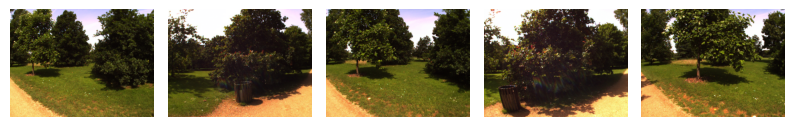

In [67]:
plot_image_grid(imgs[:5])

In [68]:
def plot_ground_truth_matrix(matrix):
    plt.figure(figsize=(8, 8))
    plt.imshow(matrix, cmap="binary", interpolation="nearest")
    plt.colorbar(label="Loop Closure (1: Closed, 0: Open)")
    plt.title("Ground Truth Matrix for Loop Closures")
    plt.xlabel("Image Index")
    plt.ylabel("Image Index")
    plt.show()

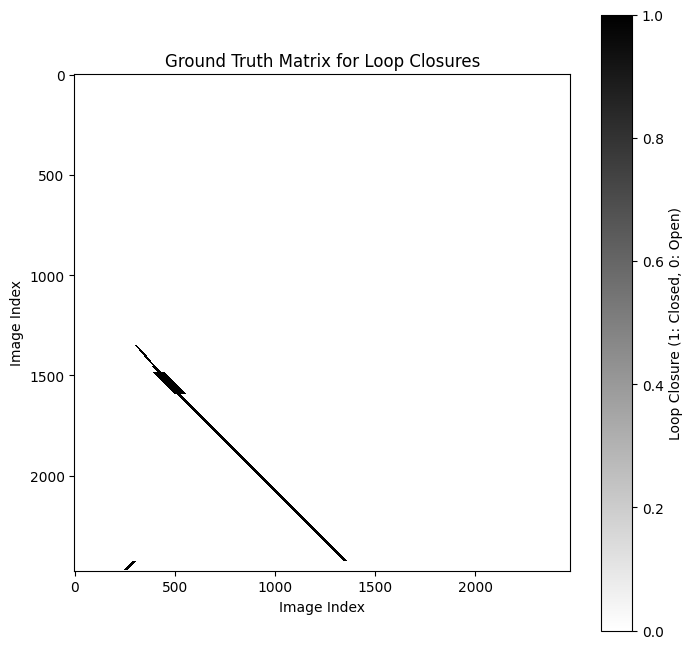

In [69]:
plot_ground_truth_matrix(gt)

Load a CNN and pass the images to get an embedding

## Resnet

In [70]:
import torch
import numpy as np
import torchvision.transforms as transforms
from torchvision import models

# Load a pre-trained model (e.g., ResNet50) and remove the final layer
model = models.resnet34(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the final classification layer
model.eval()  # Set the model to evaluation mode

# Define a preprocessing function that matches the model's input requirements
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Import Inception v3
# model = models.inception_v3(pretrained=True)
# Remove the auxiliary and final classification layers
# model.aux_logits = False
# model = torch.nn.Sequential(*list(model.children())[:-1])
# model.eval()

# Define preprocessing for Inception v3
# preprocess = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize(299),  # Inception v3 expects 299x299 input
#     transforms.CenterCrop(299),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # These values work for Inception too
# ])

def get_image_embedding(image_array, model):
    """
    Passes an image (as a NumPy array) through a pre-trained CNN and returns the final embedding.

    Args:
        image_array (np.ndarray): Input image as a NumPy array.
        model (torch.nn.Module): Pre-trained CNN model without the classification layer.

    Returns:
        torch.Tensor: Final feature embedding of shape (1, 2048) for ResNet50.
    """
    # Check if the NumPy array is in the correct format (H, W, C)
    if image_array.ndim != 3 or image_array.shape[2] != 3:
        raise ValueError("Input image_array should be in H x W x C format with 3 color channels")

    # Convert NumPy array to PIL image and preprocess
    image_tensor = preprocess(image_array).unsqueeze(0)  # Add batch dimension
    
    # Pass through the model to get the embedding
    with torch.no_grad():
        embedding = model(image_tensor)
    
    # Flatten the embedding to a 1D vector
    embedding = embedding.view(embedding.size(0), -1)
    
    return embedding

# Example usage (replace 'image_array' with your actual NumPy image)
image_array = (np.random.rand(224, 224, 3)).astype('uint8') # Example RGB image
embedding = get_image_embedding(image_array, model)
print("Embedding shape:", embedding.shape)

Embedding shape: torch.Size([1, 512])


## VGG

In [14]:
import torch
import numpy as np
import torchvision.transforms as transforms
from torchvision import models

# Load a pre-trained VGG16 model and remove the final classification layer
model = models.vgg16(pretrained=True)
model = torch.nn.Sequential(*list(model.features.children()))  # Keep only the feature extractor part
model.eval()  # Set the model to evaluation mode

# Define a preprocessing function that matches the model's input requirements
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_image_embedding(image_array, model):
    """
    Passes an image (as a NumPy array) through a pre-trained CNN and returns the final embedding.

    Args:
        image_array (np.ndarray): Input image as a NumPy array.
        model (torch.nn.Module): Pre-trained CNN model without the classification layer.

    Returns:
        torch.Tensor: Final feature embedding of shape (1, 512 * 7 * 7) for VGG16.
    """
    # Check if the NumPy array is in the correct format (H, W, C)
    if image_array.ndim != 3 or image_array.shape[2] != 3:
        raise ValueError("Input image_array should be in H x W x C format with 3 color channels")

    # Convert NumPy array to PIL image and preprocess
    image_tensor = preprocess(image_array).unsqueeze(0)  # Add batch dimension
    
    # Pass through the model to get the embedding
    with torch.no_grad():
        embedding = model(image_tensor)
    
    # Flatten the embedding to a 1D vector
    embedding = embedding.view(embedding.size(0), -1)
    
    return embedding

# Example usage (replace 'image_array' with your actual NumPy image)
# image_array = np.random.rand(224, 224, 3)  # Example RGB image
# embedding = get_image_embedding(image_array, model)
# print("Embedding shape:", embedding.shape)


/Users/rateria/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
np.transpose(imgs[0], (2, 0, 1)).shape

(3, 480, 640)

In [18]:
# sanity check
get_image_embedding(imgs[0], model)

tensor([[1.0079e+00, 4.3899e-01, 4.9953e-01, 3.1358e-01, 6.7923e-01, 1.3620e-01,
         2.9184e-02, 6.2206e-01, 1.5768e-01, 5.6780e-02, 4.3766e-01, 1.5035e+00,
         5.8456e-01, 6.8857e-01, 1.0770e+00, 2.4277e+00, 1.1631e+00, 1.4181e-01,
         7.4619e-01, 3.2324e-01, 1.4379e+00, 2.9271e-01, 2.7834e-01, 3.5369e-02,
         1.7021e-01, 1.4698e+00, 3.1322e-01, 3.2754e-01, 4.0494e-01, 5.2849e-01,
         3.1498e-01, 3.1438e-01, 1.8125e-01, 9.2794e-01, 6.6598e-01, 4.2464e-01,
         8.5633e-02, 1.4570e+00, 2.8743e-01, 1.9507e-01, 1.9737e-01, 9.6863e-02,
         1.0558e+00, 3.1291e-01, 1.0016e+00, 1.3831e-01, 5.9027e-02, 2.8457e+00,
         2.8185e-01, 8.8318e-02, 5.6176e-01, 6.6995e-01, 8.9671e-02, 2.8496e-01,
         5.8131e-01, 2.6706e-01, 1.6523e-01, 1.4350e+00, 7.4083e-01, 6.0908e-01,
         1.3329e-02, 8.1780e-01, 1.5209e+00, 1.4891e+00, 7.0428e-01, 7.9745e-01,
         1.3134e-01, 4.0205e-01, 1.0956e-01, 5.3120e-01, 1.6737e-01, 3.9368e-01,
         4.8270e-01, 2.3574e

## Data Processing for feature matching

In [19]:
from sklearn.model_selection import train_test_split

In [71]:
# Define the pickle file path
pickle_file = './data/embeddings_resnet34_city.pkl'

# Check if the pickle file exists
if os.path.exists(pickle_file):
    # Load data from the pickle file
    with open(pickle_file, 'rb') as f:
        embeddings = pickle.load(f)
    print("Data loaded from pickle file.")
else:
    # Execute some code to generate data
    embeddings = [get_image_embedding(img, model) for img in imgs]
    print("Data generated.")

    # Save data to the pickle file
    with open(pickle_file, 'wb') as f:
        pickle.dump(embeddings, f)
    print("Data saved to pickle file.")

Data loaded from pickle file.


In [72]:
embeddings = np.array([embedding.numpy() for embedding in embeddings]).reshape(len(imgs), -1)
embeddings.shape

(2474, 512)

In [73]:
def pca_red(descs, dim, eps=1e-5, whiten=True):
    """ Performs PCA + whitening on image descriptors

    Args:
        descs:  input matrix of image descriptors
        dim:    the number of principal components to reduce descs to
        eps:    small epsilon to avoid 0-division
        whiten: whether to whiten the principal components
        cache:  PCA cache (see name parameter)
        name:   used to differentiate different cached value between models

    Returns:
        descs:  the descs post-reduction
        cache:  the (updated) cache
    """
    # Zero-center data
    dmean = descs.mean(axis=0)
    descs = descs - dmean
    # Compute covariance matrix
    cov = descs.T.dot(descs) / (descs.shape[0] - 1)
    # Apply SVD
    U, S, W = np.linalg.svd(cov)

    # Project onto principal axes
    descs = descs.dot(U[:, :dim])
    # Whiten
    if whiten:
        descs = descs / np.sqrt(S[:dim] + eps)
    return descs, S

In [74]:
# sanity check
pca, S = pca_red(np.array(embeddings[:10]).reshape(10, -1), 32)

In [75]:
pca.shape

(10, 32)

Calculate and store the PCA

In [76]:
# L2 Norm
# embeddings = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [77]:
# embeddings.reshape(embeddings.shape[0], -1)[0]

In [78]:
# Define the pickle file path
pickle_file = './data/pca_resnet_34_city.pkl'
pca_dim = 256

# Check if the pickle file exists
if os.path.exists(pickle_file):
    # Load data from the pickle file
    with open(pickle_file, 'rb') as f:
        pca = pickle.load(f)
    print("Data loaded from pickle file.")
else:
    # Execute some code to generate data
    pca, _ = pca_red(embeddings, pca_dim) 
    print("Data generated.")

    # Save data to the pickle file
    with open(pickle_file, 'wb') as f:
        pickle.dump(pca, f)
    print("Data saved to pickle file.")

Data loaded from pickle file.


In [79]:
pca.shape

(2474, 256)

### Calc Similarity Matrix

In [80]:
from sklearn.cluster import KMeans

In [81]:
def cluster_kmeans(sim):
    """Run k-means on similarity matrix and segment"""
    sim_dim = sim.shape[0]
    sim = sim.reshape(-1, 1)

    # Augment with spatial coordinates
    sim_aug = np.concatenate(
        [sim,
         np.mgrid[:sim_dim, :sim_dim].reshape(-1, sim_dim ** 2).T],
        axis=1
    )

    # Empirical metric for number of loop-closures given number of images
    # in sequence (assumption: equally-spaced samples):
    n_clusters = int(np.sqrt(sim_dim))
    print('Performing clustering via KMeans(n={}).'.format(n_clusters))

    km = KMeans(n_clusters=n_clusters, max_iter=300)
    labels = km.fit_predict(sim_aug)
    print('Got cluster labels')

    for i in range(n_clusters):
        lab_idx = (labels == i)
        if lab_idx.size:
            cc = sim[lab_idx].mean()
            # cc = sim[lab_idx].max()
            sim[lab_idx] = cc

    # Re-normalize and reshape
    sim = sim.reshape(sim_dim, sim_dim) / sim.max()
    return sim

In [88]:
from sklearn.metrics.pairwise import cosine_similarity

def similarity_matrix(descs, gt, median=False, cluster=True, plot=True,
                      k_size=None, name='', threshold=None):
    """ Compute pairwise similarity between descriptors. Using provided gt to find best
    parameters given function args.

    Args:
        descs:   feature descriptors of shape (n, d)
        gt:      the ground truth
        median:  whether to use median filtering (chooses median value that obtains
                 highest avg precision...
        cluster: whether to cluster
        plot:    whether to plot matrix
        k_size:  specify None to sweep, otherwise the value to use
        name:    name for plot file+cache
    """
    print('Computing similarity matrix...')
    n = descs.shape[0]
    diffs = np.zeros((n, n))

    # Compute L2 norm of each vector
    norms = np.linalg.norm(descs, axis=1)
    descs_norm = descs / norms[:, None]

    # sim = np.dot(descs, descs.T)
    # sim = np.inner(descs.T, descs.T) / ((np.linalg.norm(descs, axis=0).reshape(-1,1)) * ((np.linalg.norm(descs, axis=0).reshape(-1,1)).T))
    sim = cosine_similarity(descs)
    # print(max(sim), min(sim))

    # Compute similarity of every vector with every vector
    # for i, desc in enumerate(descs):
    #     # Compute difference
    #     diff = np.linalg.norm(descs_norm - descs_norm[i], axis=1)
    #     diffs[i] = diff

    # # # Compute max difference
    # dmax = diffs.max()

    # # # Normalize difference and create sim matrix
    # sim = 1. - (diffs / dmax)
    print(sim.shape, gt.shape)
    assert gt.shape[0] == sim.shape[0]

    if cluster:
        sim = cluster_kmeans(sim)

    if median:
        # sim = median_filter(sim, gt, k_size=k_size)
        pass
    
    if threshold:
        sim[sim>threshold] = 1
        sim[sim<=threshold] = 0
        
    if plot:
        f, ax = plt.subplots()
        cax = ax.imshow(sim, cmap='coolwarm', interpolation='nearest',
                        vmin=0., vmax=1.)
        cbar = f.colorbar(cax, ticks=[0, 0.5, 1])
        cbar.ax.set_yticklabels(['0', '0.5', '1'])
        plt.savefig('simplot_{}.png'.format(name), format='png', dpi=150)
        plt.show()

        # Preprocess gt...
        gt = gt.copy()
        gt += gt.T  # add transpose
        gt += np.eye(gt.shape[0], dtype=gt.dtype)

        # Plot
        f, ax = plt.subplots(1, 2)
        ax[0].imshow(sim, cmap='coolwarm', interpolation='nearest',
                     vmin=0., vmax=1.)
        ax[0].set_axis_off()
        ax[0].set_title('Similarity Matrix')
        ax[1].imshow(gt, cmap='gray', interpolation='nearest',
                     vmin=0., vmax=1.)
        ax[1].set_axis_off()
        ax[1].set_title('Ground Truth')
        plt.savefig('simplot_w_gt_{}.png'.format(name), format='png', dpi=150)
        plt.show()

    return sim

Computing similarity matrix...
(2474, 2474) (2474, 2474)


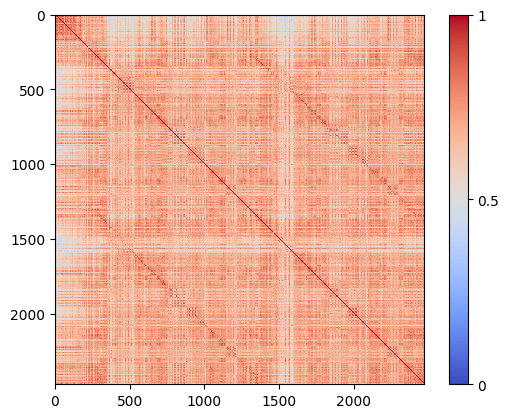

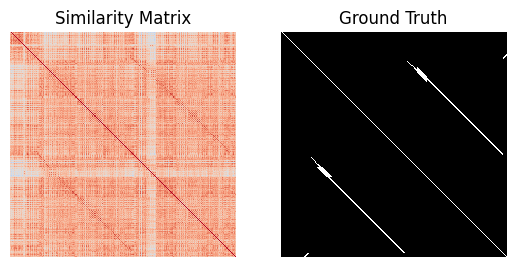

In [94]:
# just the similarity matrix using l2 norm
sim = similarity_matrix(embeddings, gt, cluster=False, threshold=None)

In [95]:
sim

array([[1.        , 0.7797348 , 0.8897334 , ..., 0.5989384 , 0.67183906,
        0.5842013 ],
       [0.7797348 , 0.99999976, 0.80701566, ..., 0.63908297, 0.77253634,
        0.6406201 ],
       [0.8897334 , 0.80701566, 0.99999964, ..., 0.658164  , 0.7413722 ,
        0.64109343],
       ...,
       [0.5989384 , 0.63908297, 0.658164  , ..., 0.99999976, 0.70707464,
        0.90185523],
       [0.67183906, 0.77253634, 0.7413722 , ..., 0.70707464, 1.0000001 ,
        0.71177274],
       [0.5842013 , 0.6406201 , 0.64109343, ..., 0.90185523, 0.71177274,
        1.0000006 ]], dtype=float32)

In [96]:
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score

In [97]:
def mean_per_class_accuracy(y_true, y_pred, n_classes=None, labels=None):
    """ Computes mean per-class accuracy

    Args:
        y_true:    the true labels
        y_pred:    the predicted labels
        n_classes: the number of classes, optional. If not provided, the number of
                   unique classes or length of `labels` if provided.
        labels:    the unique labels, optional. If not provided, unique labels are used
                   if `n_classes` not provided, otherwise range(n_classes).

    Returns:
        mean per-class accuracy
    """
    if n_classes is None:
        if labels is None:
            labels = np.unique(y_true)
        n_classes = len(labels)
    elif labels is None:
        labels = np.arange(n_classes)
    elif len(labels) != n_classes:
        raise ValueError('Number of classes specified ({}) differs from '
                         'number of labels ({}).'.format(n_classes, len(labels)))
    acc = 0.
    for c in labels:
        c_mask = (y_true == c)
        c_count = c_mask.sum()
        if c_count:  # Avoid division by 0
            # Add accuracy for class c
            acc += np.logical_and(c_mask, (y_pred == c)).sum() / c_count
    # Mean accuracy per class
    return acc / n_classes


def compute_and_plot_scores(sim, gt, model_name):
    """ Computes relevant metrics and plots results.

    Args:
        sim:        Similarity matrix
        gt:         Ground truth matrix
        model_name: Name of the model for logging
    """
    # Modify sim matrix to get "real" vector of loop-closures
    # symmetric matrix, take either diagonal matrix, rid diagonal
    sim = sim[np.tril_indices(sim.shape[0], -1)]

    # Ground truth only present in lower diagonal for Oxford datasets
    gt = gt[np.tril_indices(gt.shape[0], -1)]

    # Compute PR-curve
    precision, recall, thresholds = precision_recall_curve(gt, sim)
    average_precision = average_precision_score(gt, sim)
    print('Average Precision: {}'.format(average_precision))

    best_macc = 0.
    best_mthresh = None
    # Compute the best MPC-accuracy at hard-coded thresholds
    thresholds = np.arange(0, 1.02, 0.02)
    for thresh in thresholds:
        sim_thresh = np.zeros_like(sim)
        sim_thresh[sim >= thresh] = 1
        macc = mean_per_class_accuracy(gt, sim_thresh, n_classes=2)
        if macc > best_macc:
            best_macc = macc
            best_mthresh = thresh


    best_f1 = 0.0
    best_f1_thresh = None

    # Calculate F1 score for each threshold
    for thresh in thresholds:
        sim_thresh = np.zeros_like(sim)
        sim_thresh[sim >= thresh] = 1
        f1 = f1_score(gt, sim_thresh)
        if f1 > best_f1:
            best_f1 = f1
            best_f1_thresh = thresh

    

    sim_mthresh = np.zeros_like(sim)
    sim_mthresh[sim >= best_mthresh] = 1
    precision_at_mthresh = precision_score(gt, sim_mthresh)
    recall_at_mthresh = recall_score(gt, sim_mthresh)
    print('Best MPC-ACC (thresh={}): {}'.format(best_mthresh, best_macc))
    print('Precision (thresh={}): {}'.format(best_mthresh, precision_at_mthresh))
    print('Recall (thresh={}): {}'.format(best_mthresh, recall_at_mthresh))

    sim_f1thresh = np.zeros_like(sim)
    sim_f1thresh[sim >= best_f1_thresh] = 1
    precision_at_f1thresh = precision_score(gt, sim_f1thresh)
    recall_at_f1thresh = recall_score(gt, sim_f1thresh)
    print("Best F1 Score (thresh={}): {}".format(best_f1_thresh, best_f1))
    print('Precision (thresh={}): {}'.format(best_f1_thresh, precision_at_f1thresh))
    print('Recall (thresh={}): {}'.format(best_f1_thresh, recall_at_f1thresh))

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.3f}'.format(
        average_precision))
    plt.savefig('precision-recall_curve_{}.png'.format(model_name),
                format='png', dpi=150)
    plt.show()

Average Precision: 0.0852159370628233
Best MPC-ACC (thresh=0.06): 0.6244577476100991
Precision (thresh=0.06): 0.025656854435744014
Recall (thresh=0.06): 0.3759267497034401
Best F1 Score (thresh=0.2): 0.19622866581024043
Precision (thresh=0.2): 0.2574025036109774
Recall (thresh=0.2): 0.15854833926453143


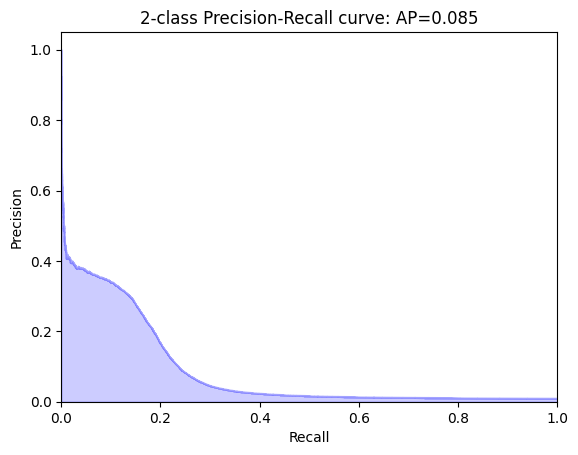

In [ ]:
compute_and_plot_scores(sim, gt, "resnet_city_without_pca")